In [1]:
pip install pywavelets scikit-image


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 5.9 MB/s eta 0:00:00


# **Import libraries**



In [2]:
import cv2
import numpy as np
import pywt
import matplotlib.pyplot as plt
from skimage import color, io
from google.colab import drive
from skimage.metrics import mean_squared_error
from google.colab.patches import cv2_imshow ## Use this to show image in colab

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Cell 1: Wavelet transform & zero coefficient --> Slides[60-63]**

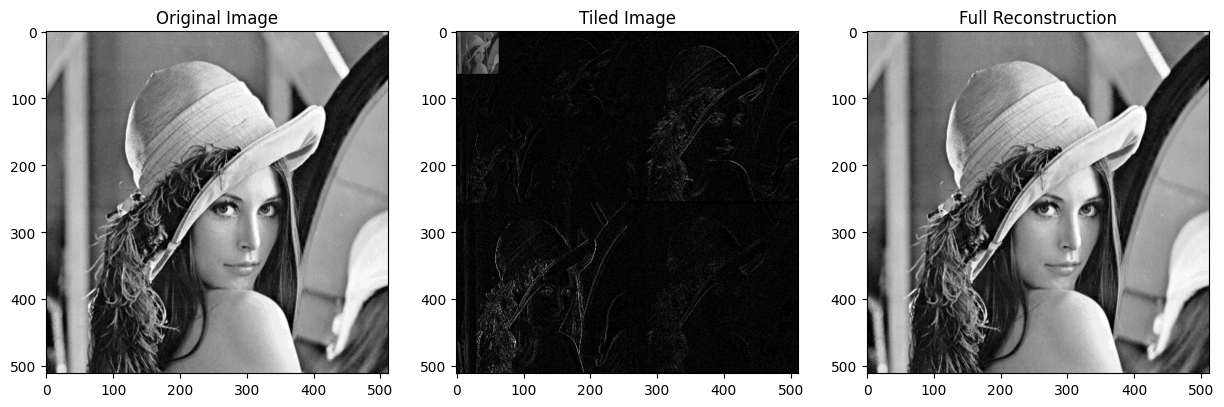


 MSE = 8.392333984375e-05


In [85]:
# Load the image
img = cv2.imread('/content/drive/MyDrive/Image_Processing_Photos/Lena.bmp', cv2.IMREAD_GRAYSCALE)

# Number of decompositions
nLevel = 3

# Perform the wavelet decomposition
cA_list, cH_list, cV_list, cD_list = [], [], [], []

start_image = img.copy()
for iLevel in range(1, nLevel + 1):
    cA, (cH, cV, cD) = pywt.dwt2(start_image, 'haar')
    cA_list.append(cA)
    cH_list.append(cH)
    cV_list.append(cV)
    cD_list.append(cD)
    start_image = cA

# Set the last level of cA to zeros
# cA_list[nLevel - 1] = np.zeros_like(cA_list[nLevel - 1])

# # Set all cV levels to zeros
# for l in range(nLevel):
#     cV_list[l] = np.zeros_like(cV_list[l])

# Create tiled image
tiled_image = cA_list[nLevel - 1]

for iLevel in range(nLevel, 0, -1):
    top_left = tiled_image
    top_right = cH_list[iLevel - 1]
    bottom_left = cV_list[iLevel - 1]
    bottom_right = cD_list[iLevel - 1]

    top_row = np.concatenate((top_left, top_right), axis=1)
    bottom_row = np.concatenate((bottom_left, bottom_right), axis=1)

    tiled_image = np.concatenate((top_row//5, bottom_row//5), axis=0)

# ============================== Reconstruct ============================= #

# Reconstruct original
full_recon = cA_list[nLevel - 1]

for iLevel in range(nLevel, 0, -1):
    full_recon = pywt.idwt2((full_recon, (cH_list[iLevel - 1], cV_list[iLevel - 1], cD_list[iLevel - 1])), 'haar')

# Convert to uint8 for display
full_recon = np.uint8(full_recon)

# Display the images
plt.figure(figsize=(15, 9))

plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(np.abs(tiled_image), cmap='gray')
plt.title('Tiled Image')

plt.subplot(1, 3, 3)
plt.imshow(full_recon, cmap='gray')
plt.title('Full Reconstruction')
plt.show()

# Calculate Mean Squared Error
mse = mean_squared_error(img, full_recon)
print("\n", "MSE =", mse)

# **Cell 2: Wavelet packet decomposition --> Slides[65-69]**

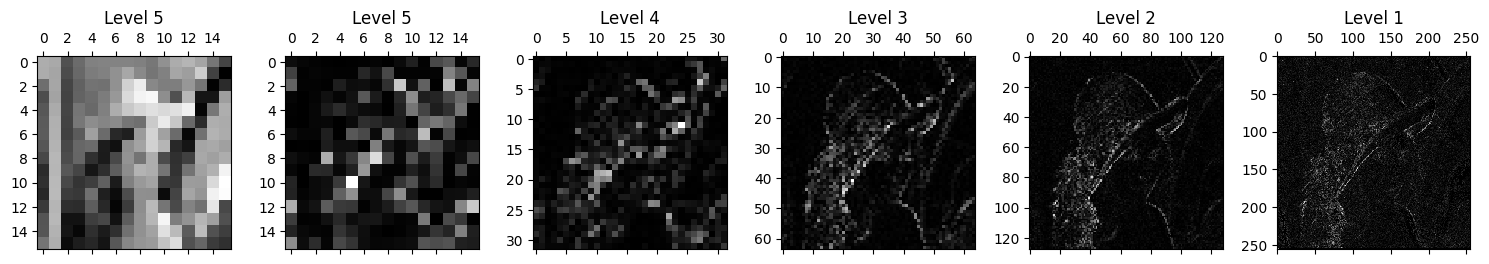

4918.937500000003


In [83]:
# Read the image and convert it to grayscale
img = cv2.imread('/content/drive/MyDrive/Image_Processing_Photos/Lena.bmp', cv2.IMREAD_GRAYSCALE)

# Wavelet packet decomposition
level = 5
coeffs = pywt.wavedec2(img, 'haar', level=level)

# Plot the wavelet packet coefficients
fig, axes = plt.subplots(1, len(coeffs), figsize=(15, 5))

for i, coeff in enumerate(coeffs):
    if len(coeff) == 3:
        for j in range(3):
            axes[i].matshow(np.abs(coeff[j]), cmap=plt.cm.gray)
            axes[i].set_title(f'Level {level - i + 1}')
    else:
        axes[i].matshow(np.abs(coeff), cmap=plt.cm.gray)
        axes[i].set_title(f'Level {level - i}')


# Adjust layout for better visibility
plt.tight_layout()
plt.show()


print(coeffs[0][0][0])
# for i in range(len(coeffs[0][:])):
#     print(i)

# **Cell 3: Gaussian pyramid --> Slides[71-77]**

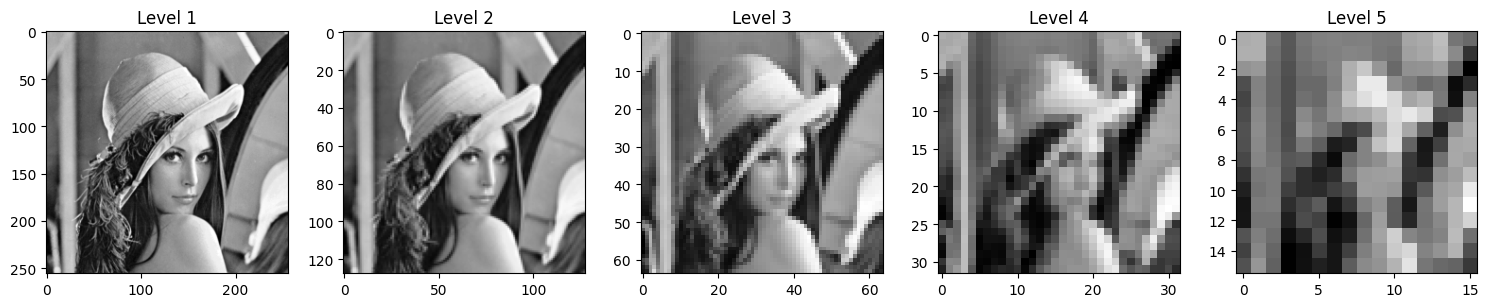

In [84]:
# Read the image and convert it to grayscale
img = cv2.imread('/content/drive/MyDrive/Image_Processing_Photos/Lena.bmp', cv2.IMREAD_GRAYSCALE)
level = 5

# Create a single subplot for all images
fig, axes = plt.subplots(1, level, figsize=(15, 3))
B = img.copy()

# Display images in the subplot
for i in range(level):
    B = cv2.GaussianBlur(B, (3,3), 1)
    B = B[::2, ::2]
    axes[i].imshow(B, cmap='gray')
    axes[i].set_title(f'Level {i + 1}')

plt.tight_layout()
plt.show()


# **Cell 4: Laplacian pyramid --> Slides[78-83]**

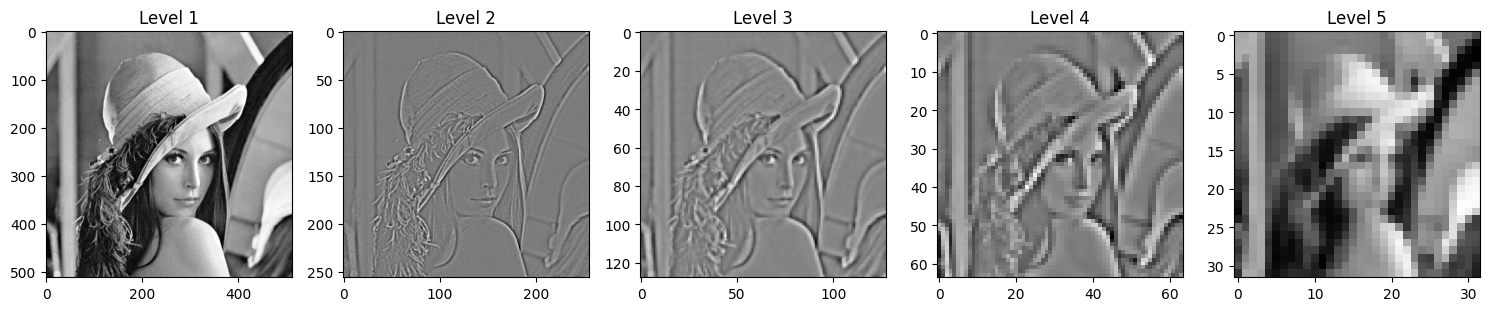

5


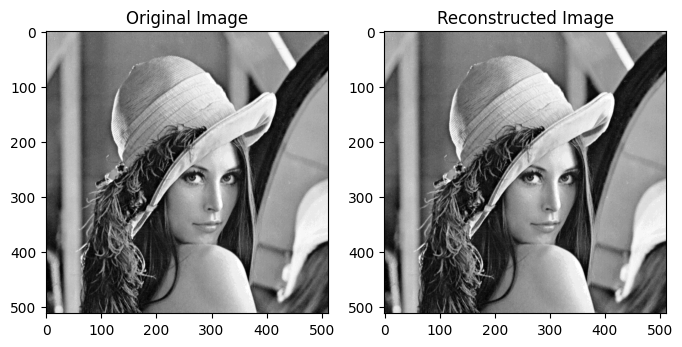


 MSE = 0.0


In [68]:
from skimage import transform

# Read the image and convert it to grayscale
img = cv2.imread('/content/drive/MyDrive/Image_Processing_Photos/Lena.bmp', cv2.IMREAD_GRAYSCALE)

# Set the number of levels
level = 5

# Create a Laplacian pyramid
pyr = []
cur_img = img

# Create a single subplot for all images
fig, axes = plt.subplots(1, level, figsize=(level * 3, 3))

for i in range(level - 1):
    md_img = transform.pyramid_reduce(cur_img, downscale=2)
    upscaled = transform.pyramid_expand(md_img, upscale=2)

    lp = cur_img - upscaled

    pyr.append(lp)

    cur_img = md_img

    # Display each level in the subplot
    axes[i].imshow(lp, cmap='gray')
    axes[i].set_title(f'Level {i + 1}')

# Add the last level to the subplot
pyr.append(md_img)
axes[level - 1].imshow(pyr[-1], cmap='gray')
axes[level - 1].set_title(f'Level {level}')

# Adjust layout for better visibility
plt.tight_layout()
plt.show()

# ====================== Reconstruct ======================== #

# Reconstruct the image from the Laplacian pyramid
reconstructed_img = pyr[-1]
for i in range(level - 2, -1, -1):
    reconstructed_img = pyr[i] + transform.pyramid_expand(reconstructed_img, upscale=2)

# Display the original and reconstructed images
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(img, cmap='gray')
axes[0].set_title('Original Image')

axes[1].imshow(reconstructed_img, cmap='gray')
axes[1].set_title('Reconstructed Image')

plt.show()

# Calculate Mean Squared Error
mse = mean_squared_error(img, reconstructed_img)
print("\n", "MSE =", mse, )

# **Cell 5: Application of DWT (noise removal) --> Slide[64:]**

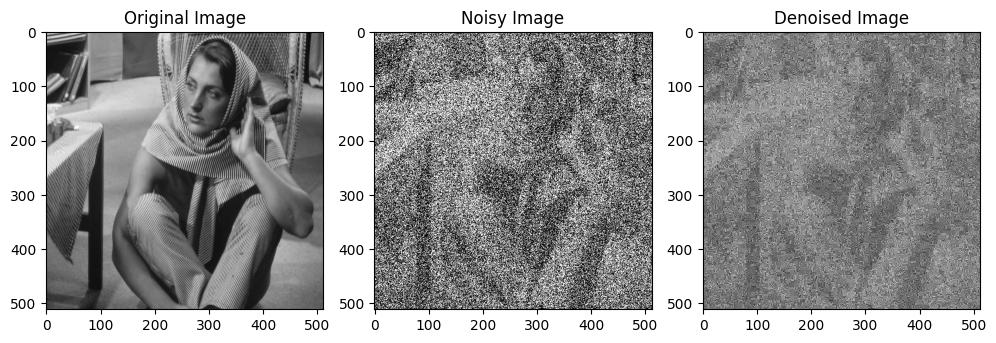

MSE BETWEEN NOISY AND ORIGINAL = 0.1718
MSE BETWEEN RECONSTRUCTED AND ORIGINAL = 0.0801


In [62]:
from skimage import util

def wavelet_denoise(image, n_level, threshold_type, threshold_value):
    cA = []
    cH = []
    cV = []
    cD = []

    # Construct wavelet coefficients
    start_image = image.copy()
    for i in range(n_level):
        cA_i, (cH_i, cV_i, cD_i) = pywt.dwt2(start_image, 'haar')

        # Apply thresholding to detail coefficients
        cH_i = pywt.threshold(cH_i, threshold_value,threshold_type)
        cV_i = pywt.threshold(cV_i, threshold_value,threshold_type)
        cD_i = pywt.threshold(cD_i, threshold_value,threshold_type)

        cA.append(cA_i)
        cH.append(cH_i)
        cV.append(cV_i)
        cD.append(cD_i)

        start_image = cA_i

    # Reconstruct the denoised image
    full_recon = cA[-1]
    for i in range(n_level - 1, -1, -1):
        full_recon = pywt.idwt2((full_recon, (cH[i], cV[i], cD[i])), 'haar')

    return full_recon

# Load the image
img = cv2.imread('/content/drive/MyDrive/Image_Processing_Photos/Barbara.bmp')
img_gray = color.rgb2gray(img)


# Add Gaussian noise
noisy_image = util.random_noise(img_gray, mode='gaussian', var=0.6)

# Perform wavelet denoising
denoised_image = wavelet_denoise(noisy_image, n_level=3, threshold_type='hard', threshold_value=0.6745)

# Display the original, noisy, and denoised images
plt.figure(figsize=(10, 4))

plt.subplot(1, 3, 1)
plt.imshow(img_gray, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(noisy_image, cmap='gray')
plt.title('Noisy Image')

plt.subplot(1, 3, 3)
plt.imshow(denoised_image, cmap='gray')
plt.title('Denoised Image')

plt.tight_layout()
plt.show()

# Display MSE between original and noisy, and original and denoised images
print(f"MSE BETWEEN NOISY AND ORIGINAL = {np.mean((img_gray - noisy_image)**2):.4f}")
print(f"MSE BETWEEN RECONSTRUCTED AND ORIGINAL = {np.mean((img_gray - denoised_image)**2):.4f}")


# **Cell 6: Application of Image Pyramids (Fast Template Matching) --> Slides[88-94]**

### Step-by-Step Explanation of the Code:

1. **Template Normalization:** Compute the mean and normalize the template by subtracting its mean and dividing by its norm.  
2. **Sliding Window:** Slide the template over the image to extract sub-regions matching the template's size.  
3. **Region Normalization:** Compute the mean and normalize each sub-region of the image.  
4. **Numerator Calculation:** Compute the dot product between the normalized template and the normalized sub-region.  
5. **Denominator Calculation:** Calculate the product of the norms of the normalized template and sub-region.  
6. **Cross-Correlation Value:** Compute the normalized cross-correlation coefficient for each position.  
7. **Result Visualization:** Generate a heatmap from the cross-correlation map to visualize areas of high similarity.

Execution Time: 59.85 seconds


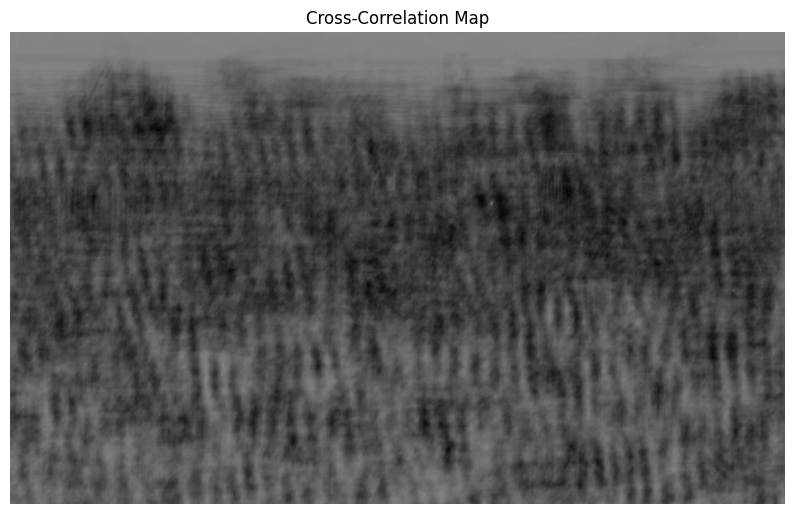

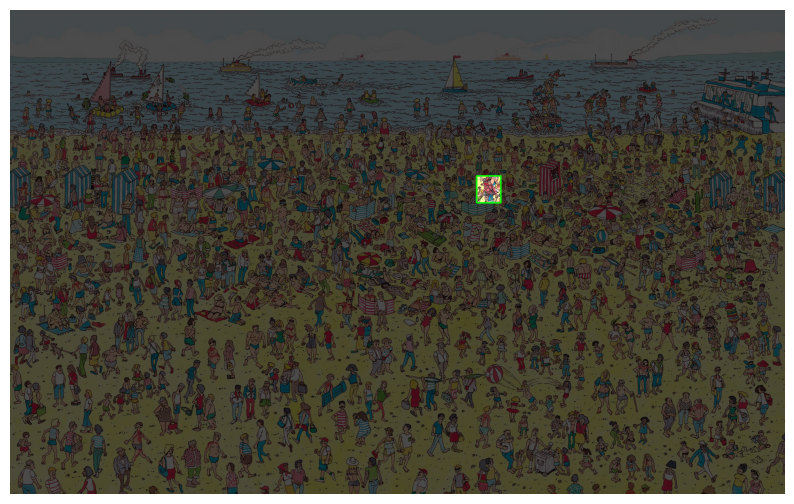

In [23]:
import time

def sum_of_squared_differences(image, template):
    I, T = image.astype('float'),template.astype('float')
    H, W = I.shape[0], I.shape[1]
    h, w = T.shape[0], T.shape[1]
    R = np.ones_like(image)*np.inf

    for i in range(W-w):
        for j in range(H-h):
            t = (I[j: j+h, i: i+w] - T).ravel() # Extract corresponding pixel differences
            R[j, i] = t.dot(t) # Calculate sum of squared differences

    return R

def template_matching(image, template):
    R = sum_of_squared_differences(image, template)
    _, _, min_loc, max_loc = cv2.minMaxLoc(-R)  # Find minimum value (highest similarity)
    top_left = max_loc
    h,w = template.shape
    bottom_right = (top_left[0] + w, top_left[1] + h)
    return R, top_left,bottom_right

def plot_image(map_puzzle,top_left,bottom_right):
  region_of_interest = map_puzzle[top_left[1] : bottom_right[1], top_left[0] : bottom_right[0]]
  mask = np.zeros(map_puzzle.shape, dtype = "uint8")
  image_map = cv2.addWeighted(map_puzzle, 0.3, mask, 0.7, 0)
  image_map[top_left[1] : bottom_right[1], top_left[0] : bottom_right[0]] = region_of_interest
  final_result = cv2.cvtColor(image_map, cv2.COLOR_RGB2BGR)
  cv2.rectangle(final_result, top_left, bottom_right, (0,255,0),4)
  return final_result

# # Compute cross-correlation map from scratch
# def cross_correlation_map_scratch(image, template):
#     """
#     Computes a cross-correlation map manually without using cv2.matchTemplate.
#     """
#     H, W = image.shape
#     h, w = template.shape
#     R = np.zeros((H - h + 1, W - w + 1), dtype=np.float32)

#     # Compute the mean of the template
#     template_mean = template.mean()
#     template_norm = np.sqrt(np.sum((template - template_mean) ** 2))

#     # Compute cross-correlation
#     for i in range(R.shape[1]):
#         for j in range(R.shape[0]):
#             region = image[j:j + h, i:i + w]
#             region_mean = region.mean()
#             numerator = np.sum((region - region_mean) * (template - template_mean))
#             denominator = np.sqrt(np.sum((region - region_mean) ** 2)) * template_norm
#             R[j, i] = numerator / denominator if denominator != 0 else 0

#     return R

def cross_correlation_map(image, template):
    """
    Computes a cross-correlation map using cv2.matchTemplate
    """
    return cv2.matchTemplate(image, template, cv2.TM_CCORR_NORMED)


# ===================== Main ========================= #

start_time = time.time()  # Start timing

# Input images
waldo_image = cv2.imread('/content/drive/MyDrive/Image_Processing_Photos/waldo.jpg')
gray_waldo_image = cv2.cvtColor(waldo_image.copy(), cv2.COLOR_BGR2GRAY)

template = cv2.imread('/content/drive/MyDrive/Image_Processing_Photos/template.png')
gray_template = cv2.cvtColor(template.copy(), cv2.COLOR_BGR2GRAY)

# template matching procces
R,  top_left,bottom_right = template_matching(gray_waldo_image, gray_template)

# Generate cross-correlation map
# cc_map_scratch = cross_correlation_map_scratch(gray_waldo_image, gray_template)
cc_map = cross_correlation_map(gray_waldo_image, gray_template)

end_time = time.time()  # End timing
execution_time = end_time - start_time
print(f"Execution Time: {execution_time:.2f} seconds")

# Plot the Cross-Correlation Map
plt.figure(figsize=(10, 10))
plt.title('Cross-Correlation Map')
plt.axis('off')
plt.imshow(cc_map, cmap='gray')
plt.show()

# Display the proccessed image
result = plot_image(waldo_image,top_left,bottom_right)
plt.figure(figsize = (10, 10))
plt.axis('off')
plt.imshow(result)


# **Cell 7: Application of Image Pyramids (Fast Template Matching) --> Slides[88-94]**

### Step-by-Step Explanation of the Code:

1. **Gaussian Pyramid Creation**: Create progressively downscaled versions of the input image and template.  
2. **SSD Calculation**: Compute the Sum of Squared Differences between the template and regions in the search image.  
3. **Coarse-to-Fine Matching**: Perform matching at lower resolutions first, narrowing the search region at higher resolutions.  
4. **Match Localization**: Determine the best match coordinates at each pyramid level and refine them iteratively.  
5. **Result Visualization**: Draw a rectangle around the matched region in the original image for display.

Execution Time: 3.46 seconds


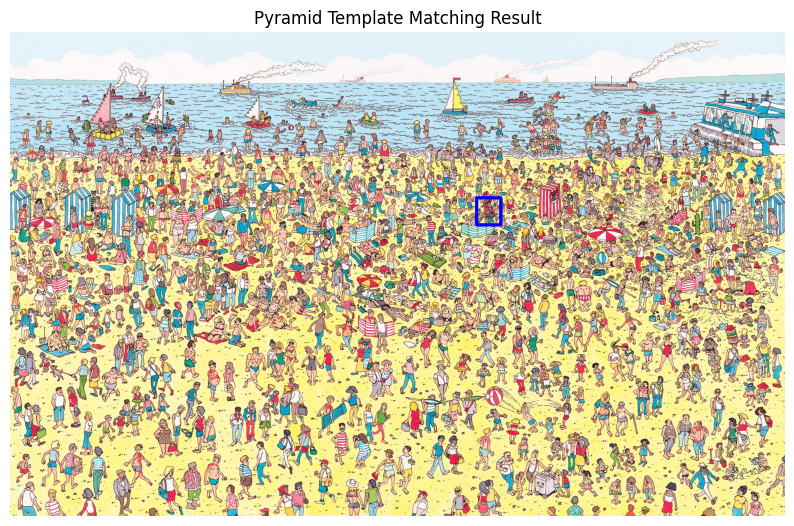

In [24]:
import time

def create_pyramid(image, levels):
    """
    Creates a Gaussian pyramid for the given image.
    """
    pyramid = [image]
    for _ in range(levels - 1):
        image = cv2.pyrDown(image)
        pyramid.append(image)
    return pyramid

def sum_of_squared_differences(image, template):
    """
    Computes the Sum of Squared Differences (SSD) between the image and the template.
    """
    I, T = image.astype('float32'), template.astype('float32')
    h, w = T.shape[:2]
    result = np.zeros((I.shape[0] - h + 1, I.shape[1] - w + 1), dtype='float32')

    # Efficient SSD calculation
    for y in range(result.shape[0]):
        for x in range(result.shape[1]):
            region = I[y:y + h, x:x + w]
            diff = region - T
            result[y, x] = np.sum(diff ** 2)

    return result

def pyramid_template_matching(image, template, pyramid_levels):
    """
    Performs pyramid-based template matching using Sum of Squared Differences (SSD).
    """
    # Create pyramids for image and template
    image_pyramid = create_pyramid(image, pyramid_levels)
    template_pyramid = create_pyramid(template, pyramid_levels)

    best_top_left = None
    scale_factor = 1

    for level in range(pyramid_levels - 1, -1, -1):
        img = image_pyramid[level]
        tmpl = template_pyramid[level]

        if best_top_left is None:
            # Start search in the entire image
            search_region = img
        else:
            # Narrow the search region
            x, y = best_top_left
            x, y = int(x * 2), int(y * 2)  # Upscale coordinates
            h, w = tmpl.shape[:2]
            h_half, w_half = h // 2, w // 2

            # Define a search region around the previous match
            x_start = max(0, x - w_half)
            x_end = min(img.shape[1], x + w_half + w)
            y_start = max(0, y - h_half)
            y_end = min(img.shape[0], y + h_half + h)

            search_region = img[y_start:y_end, x_start:x_end]

        # Perform SSD matching
        R = sum_of_squared_differences(search_region, tmpl)
        min_val, _, min_loc, _ = cv2.minMaxLoc(R)

        # Adjust coordinates for the current level
        if best_top_left is None:
            best_top_left = min_loc
        else:
            dx, dy = min_loc
            best_top_left = (x_start + dx, y_start + dy)

    # Compute bounding box for the best match
    top_left = best_top_left
    h, w = template.shape[:2]
    bottom_right = (top_left[0] + w, top_left[1] + h)
    return top_left, bottom_right

def plot_image(image, top_left, bottom_right):
    """
    Highlights the matched region in the image.
    """
    result = image.copy()
    cv2.rectangle(result, top_left, bottom_right, (255, 0, 0), 10)
    return cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

# =========================== Main ========================== #

start_time = time.time()  # Start timing

# Input images
waldo_image = cv2.imread('/content/drive/MyDrive/Image_Processing_Photos/waldo.jpg')
gray_waldo_image = cv2.cvtColor(waldo_image.copy(), cv2.COLOR_BGR2GRAY)

template = cv2.imread('/content/drive/MyDrive/Image_Processing_Photos/template.png')
gray_template = cv2.cvtColor(template.copy(), cv2.COLOR_BGR2GRAY)

# Pyramid levels
pyramid_levels = 3

# Perform pyramid template matching
top_left, bottom_right = pyramid_template_matching(gray_waldo_image, gray_template, pyramid_levels)

end_time = time.time()  # End timing
execution_time = end_time - start_time
print(f"Execution Time: {execution_time:.2f} seconds")

# Visualize the result
result = plot_image(waldo_image, top_left, bottom_right)

plt.figure(figsize=(10, 10))
plt.imshow(result)
plt.axis('off')
plt.title('Pyramid Template Matching Result')
plt.show()
